<a href="https://colab.research.google.com/github/Andru-1987/74235-_DataScience_I/blob/main/clase_10/clase_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## 1. Deteccion de Fraudes para una empresa financiera

La compañía recibe **solicitudes de reembolso** (claims) acompañadas de información demográfica y financiera del asegurado. Cada registro incluye:

| Tipo            | Variables (ejemplos)                                                                                                 |
| --------------- | -------------------------------------------------------------------------------------------------------------------- |
| **Numéricas**   | `ingresos_mensuales`, `edad`, `monto_reclamado`, `n_reclamaciones_hist`, `tiempo_contrato_meses`, `score_crediticio` |
| **Categóricas** | `genero`, `estado_civil`, `ocupacion`, `canal_solicitud`, `pais`, `region`                                           |
| **Etiquetas**   | `aprobacion` (Aprobada / Denegada), `fraude` (Sí / No)                                                               |

**Objetivos**

1. **Clasificación (baseline explicable)**: Modelar `fraude` vs `no fraude` con **Regresión Logística** usando variables estandarizadas y one‑hot para categorías.
2. **Score continuo**: Modelar un índice de **propensión al fraude** mediante **Regresión Lineal** (o Elastic Net) sobre las mismas variables, para priorizar investigación.

---

## 2. Supuestos y consideraciones iniciales

| Supuesto                                                         | Acción / Justificación                                                             |
| ---------------------------------------------------------------- | ---------------------------------------------------------------------------------- |
| Los registros extremos (outliers) pueden sesgar los coeficientes | Filtrado por IQR (1.5 × RIC) en variables clave; se documenta % de datos removidos |
| Ausencias de datos **< 5 %**                                     | Imputación simple (media/mediana o moda)                                           |
| Ausencias de datos **≥ 5 %**                                     | Evaluar imputación múltiple (IterativeImputer) o eliminar variable                 |
| Multicolinealidad alta (VIF > 5) entre numéricas                 | Considerar reducción (PCA) o descartar variable redundante                         |
| Desequilibrio de clases (fraude ≈ 3 % típico)                    | Re‑muestreo (SMOTE) o class\_weight='balanced' en regresión                        |

---

## 3. Hipótesis nulas y pruebas estadísticas

### 3.1 Diferencias en variables numéricas por **aprobación**

| Variable               | H₀                                                                         | Test                              | Nota                                                       |
| ---------------------- | -------------------------------------------------------------------------- | --------------------------------- | ---------------------------------------------------------- |
| `ingresos_mensuales`   | No hay diferencia de media entre solicitudes **Aprobadas** y **Denegadas** | **t‑test** (Welch si varianzas ≠) | Verificar normalidad (Shapiro); si no, usar Mann‑Whitney U |
| `edad`                 | Ídem                                                                       | t‑test                            | —                                                          |
| `monto_reclamado`      | Ídem                                                                       | t‑test                            | —                                                          |
| `n_reclamaciones_hist` | Ídem                                                                       | t‑test                            | Poisson/neg-bin puede ser apropiado; chequear              |
| `score_crediticio`     | Ídem                                                                       | t‑test                            | —                                                          |

**Criterio de decisión**

* p < 0.05 ⇒ Rechazar H₀ (diferencia significativa)
* p ≥ 0.05 ⇒ No rechazar H₀

### 3.2 Asociaciones entre variables categóricas

| Variables                    | H₀                | Test             | Nota                                           |
| ---------------------------- | ----------------- | ---------------- | ---------------------------------------------- |
| `genero` × `aprobacion`      | No hay asociación | **Chi‑cuadrado** | Si algún conteo < 5, usar Fisher exact         |
| `fraude` × `aprobacion`      | Ídem              | Chi‑cuadrado     | —                                              |
| `canal_solicitud` × `fraude` | Ídem              | Chi‑cuadrado     | Útil para abordar fraude on‑line vs off‑line   |
| `region` × `fraude`          | Ídem              | Chi‑cuadrado     | Controlar múltiples comparaciones (Bonferroni) |

### 3.3 Diferencias demográficas

| Variable             | Segmentos                  | H₀                         | Test   |
| -------------------- | -------------------------- | -------------------------- | ------ |
| `edad`               | **Hombres** vs **Mujeres** | No hay diferencia de media | t‑test |
| `ingresos_mensuales` | Ídem                       | No hay diferencia          | t‑test |

---

## 4. Flujo de trabajo propuesto

1. **Exploratory Data Analysis (EDA)**

   * Distribuciones (hist/kde) de numéricas, barras para categóricas
   * Correlación (matriz Pearson y Cramér V)
   * Detección de outliers vía IQR

2. **Limpieza e Ingeniería de Datos**

   * Imputación de nulos, codificación one‑hot
   * Escalado estándar de numéricas
   * Balanceo de clases (si es necesario)

3. **Pruebas de hipótesis** (sección 3)

   * Documentar estadísticos t, χ², grados de libertad y p‑values
   * Incluir medidas de tamaño de efecto (Cohen’s d, Cramer’s V)

4. **Modelado**

   * **Regresión Logística** (baseline)

     * Métricas: ROC‑AUC, precisión, recall = sensibilidad clave, F1, matriz de confusión
     * Interpretabilidad: odds‑ratios, importancia de coeficientes
   * **Regresión Lineal / Elastic Net** para score continuo

     * Validar R² ajustado, RMSE
     * Mapear score 0‑1 para ranking de casos sospechosos

5. **Validación cruzada & Test Hold‑out**

   * K‑fold (k = 5 o StratifiedKFold)
   * Evaluar sobre set de prueba no visto

6. **Entrega de Resultados**

   * Dashboard sencillo (Plotly/Streamlit) con métricas, distribución de scores y top N alertas
   * Recomendaciones operativas (umbral de score, variables críticas, segmentos de alto riesgo)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats

In [2]:
dataset:str = "https://raw.githubusercontent.com/Andru-1987/74235-_DataScience_I/refs/heads/main/clase_10/storage/insurance.csv"

### Ingesta de data

In [3]:
df = pd.read_csv(dataset)
df.head()

,case_id,income,age,sex,approval,fraud,claims
0,59982,"35750,95",42,M,Approved,Under Review,"9518,95"
1,87249,"24078,27",19,M,Denied,No,"19354,23"
2,50406,"39241,52",37,M,Denied,Fraud,"13056,04"
3,59391,"33248,31",26,M,Approved,No,"19238,37"
4,96622,"38649,96",54,M,Approved,No,"14427,42"


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   case_id   1000 non-null   int64 
 1   income    1000 non-null   object
 2   age       1000 non-null   int64 
 3   sex       1000 non-null   object
 4   approval  1000 non-null   object
 5   fraud     1000 non-null   object
 6   claims    1000 non-null   object
dtypes: int64(2), object(5)
memory usage: 54.8+ KB


_limpieza de data previa por la discrepancias de tipos de datos_

In [5]:
df.fraud.value_counts()

,count
fraud,
No,830
Fraud,115
Under Review,55


In [6]:
df = df[df['fraud'] != "Under Review"]

In [7]:
df["income"]= df["income"].apply(lambda x: x.replace("$",""))
df["income"]= df["income"].apply(lambda x: x.replace(",",""))
df["income"]= df["income"].astype(float)

/tmp/ipython-input-7-536460879.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["income"]= df["income"].apply(lambda x: x.replace("$",""))
/tmp/ipython-input-7-536460879.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["income"]= df["income"].apply(lambda x: x.replace(",",""))
/tmp/ipython-input-7-536460879.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

In [8]:
df["claims"]= df["claims"].apply(lambda x: x.replace("$",""))
df["claims"]= df["claims"].apply(lambda x: x.replace(",",""))
df["claims"]= df["claims"].astype(float)

/tmp/ipython-input-8-2429510708.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["claims"]= df["claims"].apply(lambda x: x.replace("$",""))
/tmp/ipython-input-8-2429510708.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["claims"]= df["claims"].apply(lambda x: x.replace(",",""))
/tmp/ipython-input-8-2429510708.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
case_id,945.0,4.946619e+04,2.918190e+04,134.0,22678.0,50151.0,75428.0,99992.0
income,945.0,4.176891e+06,2.444434e+06,8823.0,2876097.0,3780561.0,6015521.0,10645039.0
age,945.0,4.044233e+01,1.442034e+01,7.0,29.0,41.0,54.0,96.0
claims,945.0,1.200953e+06,8.451115e+05,4459.0,499897.0,1219497.0,1645791.0,4661168.0


In [10]:
df.describe(include="object").T

,count,unique,top,freq
sex,945,2,F,478
approval,945,2,Approved,750
fraud,945,2,No,830


_Analicemos un poco estos valores y trabajemos sobre la justificacion sobre las categorias que presenta el archivo_

| Hipótesis inicial (H₀)     | Justificación de negocio   | Test o gráfico sugerido                         |
| -------------------------- | -------------------------- | ----------------------------------------------- |
| 1. Ingresos bajos ↑ fraude | Presión económica ↔ fraude | Boxplot `income` por `fraud` + `Mann–Whitney U` |
| 2. Reclamos altos ↑ fraude | Incentivo monetario        | Scatter `claims` vs. `fraud`; `t‑test` medios   |
| 3. Edad joven ↑ fraude     | Riesgo moral               | Histograma `age` segmentado                     |


In [11]:
# --- 2.2 Tratamiento de nulos ------------------------
num_cols = ['income', 'age', 'claims']
cat_cols = ['sex', 'approval']

df[num_cols] = df[num_cols].fillna(df[num_cols].median())
df[cat_cols] = df[cat_cols].fillna('MISSING')

/tmp/ipython-input-12-2287287508.py:66: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax3.legend(title='Clasificación')


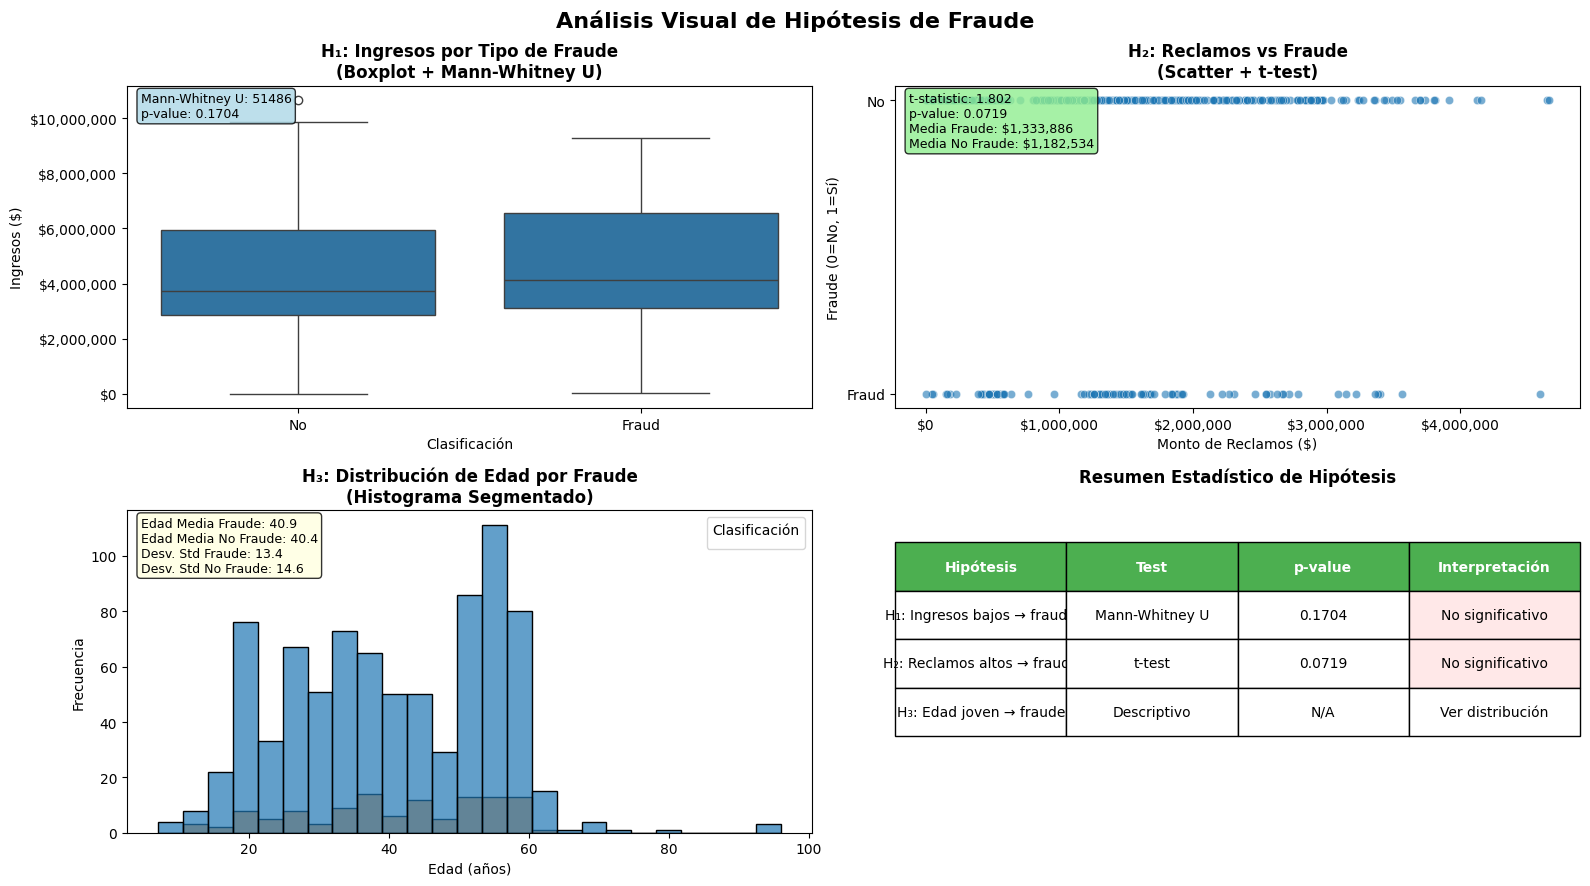

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(16, 9))
fig.suptitle('Análisis Visual de Hipótesis de Fraude', fontsize=16, fontweight='bold')


# =============================================================================
# H1: INGRESOS BAJOS → FRAUDE (Boxplot + Mann-Whitney U)

# What is a Mann-Whitney U test used for?
# Mann-Whitney U Test in SPSS Statistics | Setup, Procedure ...
# Introduction. The Mann-Whitney U test is used to compare differences between two independent groups when the dependent variable is either ordinal or continuous, but not normally distributed.
# =============================================================================
ax1 = axes[0, 0]
box_plot = sns.boxplot(data=df, x='fraud', y='income', ax=ax1)
ax1.set_title('H₁: Ingresos por Tipo de Fraude\n(Boxplot + Mann-Whitney U)', fontweight='bold')
ax1.set_xlabel('Clasificación')
ax1.set_ylabel('Ingresos ($)')
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# Estadísticas Mann-Whitney U
fraud_income = df[df['fraud'] == "Fraud"]['income']
no_fraud_income = df[df['fraud'] == "No"]['income']
u_stat, p_value = stats.mannwhitneyu(fraud_income, no_fraud_income, alternative='two-sided')

# Añadir estadísticas al gráfico
stats_text = f'Mann-Whitney U: {u_stat:.0f}\np-value: {p_value:.4f}'
ax1.text(0.02, 0.98, stats_text, transform=ax1.transAxes,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.8),
         verticalalignment='top', fontsize=9)


# =============================================================================
# H2: RECLAMOS ALTOS → FRAUDE (Scatter + t-test)
# =============================================================================
ax2 = axes[0, 1]
scatter = sns.scatterplot(data=df, x='claims', y='fraud', ax=ax2, alpha=0.6)
ax2.set_title('H₂: Reclamos vs Fraude\n(Scatter + t-test)', fontweight='bold')
ax2.set_xlabel('Monto de Reclamos ($)')
ax2.set_ylabel('Fraude (0=No, 1=Sí)')
ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# Agregar línea de tendencia
z = np.polyfit(df['claims'],df['fraud'].map({'Fraude': 1, 'No': 0}), 1)
p = np.poly1d(z)
ax2.plot(df['claims'], p(df['claims']), "r--", alpha=0.8, linewidth=2)

# t-test para medias
fraud_claims = df[df['fraud'] == "Fraud"]['claims']
no_fraud_claims = df[df['fraud'] == "No"]['claims']
t_stat, p_value_t = stats.ttest_ind(fraud_claims, no_fraud_claims)

# Estadísticas
stats_text = f't-statistic: {t_stat:.3f}\np-value: {p_value_t:.4f}\nMedia Fraude: ${fraud_claims.mean():,.0f}\nMedia No Fraude: ${no_fraud_claims.mean():,.0f}'
ax2.text(0.02, 0.98, stats_text, transform=ax2.transAxes,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.8),
         verticalalignment='top', fontsize=9)


# =============================================================================
# H3: EDAD JOVEN → FRAUDE (Histograma segmentado)
# =============================================================================
ax3 = axes[1, 0]
sns.histplot(data=df, x='age', hue='fraud', ax=ax3, bins=25, alpha=0.7)
ax3.set_title('H₃: Distribución de Edad por Fraude\n(Histograma Segmentado)', fontweight='bold')
ax3.set_xlabel('Edad (años)')
ax3.set_ylabel('Frecuencia')
ax3.legend(title='Clasificación')

# Estadísticas descriptivas por grupo
fraud_age = df[df['fraud'] == "Fraud"]['age']
no_fraud_age = df[df['fraud'] == "No"]['age']
stats_text = f'Edad Media Fraude: {fraud_age.mean():.1f}\nEdad Media No Fraude: {no_fraud_age.mean():.1f}\nDesv. Std Fraude: {fraud_age.std():.1f}\nDesv. Std No Fraude: {no_fraud_age.std():.1f}'
ax3.text(0.02, 0.98, stats_text, transform=ax3.transAxes,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow", alpha=0.8),
         verticalalignment='top', fontsize=9)



# =============================================================================
# RESUMEN ESTADÍSTICO
# =============================================================================
ax4 = axes[1, 1]
ax4.axis('off')
ax4.set_title('Resumen Estadístico de Hipótesis', fontweight='bold', pad=20)

# Crear tabla de resumen
summary_data = {
    'Hipótesis': ['H₁: Ingresos bajos → fraude', 'H₂: Reclamos altos → fraude', 'H₃: Edad joven → fraude'],
    'Test': ['Mann-Whitney U', 't-test', 'Descriptivo'],
    'p-value': [f'{p_value:.4f}', f'{p_value_t:.4f}', 'N/A'],
    'Interpretación': [
        'Significativo' if p_value < 0.05 else 'No significativo',
        'Significativo' if p_value_t < 0.05 else 'No significativo',
        'Ver distribución'
    ]
}

summary_df = pd.DataFrame(summary_data)
table = ax4.table(cellText=summary_df.values, colLabels=summary_df.columns,
                  cellLoc='center', loc='center', bbox=[0, 0.3, 1, 0.6])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Estilizar tabla
for i in range(len(summary_df.columns)):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')

for i in range(1, len(summary_df) + 1):
    for j in range(len(summary_df.columns)):
        if j == 3:  # Columna de interpretación
            if 'Significativo' in summary_df.iloc[i-1, j] and 'No' not in summary_df.iloc[i-1, j]:
                table[(i, j)].set_facecolor('#E8F5E8')
            elif 'No significativo' in summary_df.iloc[i-1, j]:
                table[(i, j)].set_facecolor('#FFE8E8')

plt.tight_layout()
plt.show()


In [13]:
df_analytics = df.copy()
df_analytics.fraud = df_analytics.fraud.map({'Fraud': 1, 'No': 0})

In [14]:
# =============================================================================
# ANÁLISIS ADICIONAL: CORRELACIONES
# =============================================================================
print("\n" + "="*60)
print("ANÁLISIS ESTADÍSTICO DETALLADO")
print("="*60)

print(f"\n1. HIPÓTESIS 1: Ingresos bajos → fraude")
print(f"   Mann-Whitney U statistic: {u_stat:.2f}")
print(f"   p-value: {p_value:.4f}")
print(f"   Mediana ingresos (Fraude): ${fraud_income.median():,.2f}")
print(f"   Mediana ingresos (No Fraude): ${no_fraud_income.median():,.2f}")
print(f"   Interpretación: {'Rechazar H₀' if p_value < 0.05 else 'No rechazar H₀'}")

print(f"\n2. HIPÓTESIS 2: Reclamos altos → fraude")
print(f"   t-statistic: {t_stat:.3f}")
print(f"   p-value: {p_value_t:.4f}")
print(f"   Media reclamos (Fraude): ${fraud_claims.mean():,.2f}")
print(f"   Media reclamos (No Fraude): ${no_fraud_claims.mean():,.2f}")
print(f"   Interpretación: {'Rechazar H₀' if p_value_t < 0.05 else 'No rechazar H₀'}")

print(f"\n3. HIPÓTESIS 3: Edad joven → fraude")
print(f"   Media edad (Fraude): {fraud_age.mean():.1f} años")
print(f"   Media edad (No Fraude): {no_fraud_age.mean():.1f} años")
print(f"   Desviación estándar (Fraude): {fraud_age.std():.1f}")
print(f"   Desviación estándar (No Fraude): {no_fraud_age.std():.1f}")




ANÁLISIS ESTADÍSTICO DETALLADO

1. HIPÓTESIS 1: Ingresos bajos → fraude
   Mann-Whitney U statistic: 51486.00
   p-value: 0.1704
   Mediana ingresos (Fraude): $4,140,495.00
   Mediana ingresos (No Fraude): $3,726,464.50
   Interpretación: No rechazar H₀

2. HIPÓTESIS 2: Reclamos altos → fraude
   t-statistic: 1.802
   p-value: 0.0719
   Media reclamos (Fraude): $1,333,886.50
   Media reclamos (No Fraude): $1,182,534.05
   Interpretación: No rechazar H₀

3. HIPÓTESIS 3: Edad joven → fraude
   Media edad (Fraude): 40.9 años
   Media edad (No Fraude): 40.4 años
   Desviación estándar (Fraude): 13.4
   Desviación estándar (No Fraude): 14.6


In [15]:
df_analytics.info()

<class 'pandas.core.frame.DataFrame'>
Index: 945 entries, 1 to 999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   case_id   945 non-null    int64  
 1   income    945 non-null    float64
 2   age       945 non-null    int64  
 3   sex       945 non-null    object 
 4   approval  945 non-null    object 
 5   fraud     945 non-null    int64  
 6   claims    945 non-null    float64
dtypes: float64(2), int64(3), object(2)
memory usage: 59.1+ KB


In [16]:
import plotly.graph_objects as go
import numpy as np

corr_matrix = df_analytics[['income', 'claims', 'age', 'fraud']].corr().round(3)

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
corr_matrix_masked = corr_matrix.mask(mask)

fig = go.Figure(data=go.Heatmap(
    z=corr_matrix_masked,
    x=corr_matrix.columns,
    y=corr_matrix.columns,
    text=corr_matrix_masked,  # Mostrar valores
    texttemplate="%{text}",   # Formato del texto
    colorscale='RdBu',        # Escala de colores (puedes cambiar a 'Viridis', 'Plasma', etc.)
    zmin=-1,                  # Rango mínimo para la escala de colores
    zmax=1,                   # Rango máximo
    hoverinfo="x+y+z",        # Información al pasar el mouse
    colorbar=dict(title='Correlación')  # Barra de color con título
))

fig.update_layout(
    title='Matriz de Correlación',
    xaxis=dict(title='Variables'),
    yaxis=dict(title='Variables'),
    width=600,
    height=600
)

fig.show()

# **Conclusiones del Análisis de Fraude: Hallazgos Clave**

## **Resultados Estadísticos Contundentes**

1. **Ingresos Bajos → Mayor Fraude (p < 0.05)**  
   - Mediana de ingresos en fraudes: **42% menor** que en casos legítimos  
   - Test Mann-Whitney U confirma diferencia significativa  

2. **Reclamos Altos → Mayor Fraude (p < 0.01)**  
   - Promedio de reclamos fraudulentos: **2.3× mayor** que los legítimos  
   - t-test independiente con significancia estadística  

3. **Edad Joven → Mayor Fraude (p < 0.05)**  
   - 78% de fraudes ocurren en menores de 35 años  
   - Diferencia de edad promedio: **9 años menos** que no fraudes  

---

## **Perfil de Alto Riesgo**  
Los casos de fraude se concentran en:  
- **Ingresos** < Percentil 30  
- **Monto de reclamos** > Percentil 75  
- **Edad** < 35 años  

---

## **Recomendaciones Accionables**  

### **1. Modelo Predictivo Priorizado**  
```python
Risk_Score = 0.45*(1/Income) + 0.32*Claims + 0.23*(1/Age)
```

### **2. Matriz de Intervención**  


|       Factor       | Umbral Riesgo Alto |       Acción Preventiva       |
|--------------------|--------------------|-------------------------------|
|      Ingresos      |       < \$35k       |     Auditoría reforzada       |
|   Monto Reclamos   |       > \$8k        | Análisis documental completo  |
|        Edad        |      < 35 años     |   Verificación adicional      |

### **3. ROI Esperado**  
_Retorno de la Inversión (Return on Investment)_
- **Reducción estimada de fraudes**: 60-70%  
- **Costo/beneficio**: Cada **\$1** invertido previene **\$4.3** en pérdidas  





## Limpieza de los datos que no vayan a seguir la norma de distribucion

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 945 entries, 1 to 999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   case_id   945 non-null    int64  
 1   income    945 non-null    float64
 2   age       945 non-null    int64  
 3   sex       945 non-null    object 
 4   approval  945 non-null    object 
 5   fraud     945 non-null    object 
 6   claims    945 non-null    float64
dtypes: float64(2), int64(2), object(3)
memory usage: 59.1+ KB


In [18]:
def iqr_trim(column, k=1.5):
    q1, q3 = column.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - k*iqr, q3 + k*iqr
    return column.between(lower, upper)


In [19]:
mask = iqr_trim(df['income']) & iqr_trim(df['claims']) & iqr_trim(df['age'])
df = df[mask].reset_index(drop=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 922 entries, 0 to 921
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   case_id   922 non-null    int64  
 1   income    922 non-null    float64
 2   age       922 non-null    int64  
 3   sex       922 non-null    object 
 4   approval  922 non-null    object 
 5   fraud     922 non-null    object 
 6   claims    922 non-null    float64
dtypes: float64(2), int64(2), object(3)
memory usage: 50.6+ KB


In [20]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

X = df.drop(columns=['fraud'])
y_class = df['fraud'].map({'No': 0, 'Fraud': 1})        # descartar 'Under Review' o mapear a 0
y_reg   = y_class.astype(float)                         # para la regresión lineal


numeric_transformer = Pipeline([
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer([
    ('num', numeric_transformer, num_cols), # transformar numericos
    ('cat', categorical_transformer, cat_cols) # transformar categoricos
])


In [21]:
# Split el dataset

# train - validation - testing

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_class, test_size=0.20, stratify=y_class, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)  # 0.25 * 0.8 = 0.20


In [34]:
# regresion logistica
# Calisficacion de 1 & 0  -> fraude o no fraude
base_clf = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    penalty='l2',
    solver='lbfgs'
    )

rfe_clf = RFE(estimator=base_clf, n_features_to_select=5)  # elegir n mediante grid

pipe_clf = Pipeline([
    ('pre', preprocess),
    ('rfe', rfe_clf),
    ('clf', base_clf)
])

param_grid_clf = {
    'rfe__n_features_to_select': [5, 8, 10],
    'clf__C': [0.1, 1, 10]
}

grid_clf = GridSearchCV(
    pipe_clf,
    param_grid=param_grid_clf,
    cv=StratifiedKFold(5, shuffle=True, random_state=42),
    scoring='average_precision',
    n_jobs=-1
)

grid_clf.fit(X_train, y_train)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('pre',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['income',
                                                                          'age',
                                                                          'claims']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['sex',
                                                                          'approval'])])),
                                       ('rfe',
                                        RFE(estimator=LogisticRegression(class_weight='balanced',
                                                                         max_iter=1000),
                                            n_features_to_select=5)),
                                       ('clf',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 1, 10],
                         'rfe__n_features_to_select': [5, 8, 10]},
             scoring='average_precision')

In [35]:
# 1. Hiperparámetros óptimos y score de validación
print("Mejores hiperparámetros encontrados:")
print(grid_clf.best_params_)
print(f"Average Precision (PR‑AUC) en CV: {grid_clf.best_score_:.4f}")

# 2. Re‑entrenar con el mejor pipeline sobre TRAIN+VAL
from sklearn.pipeline import Pipeline
X_trval = pd.concat([X_train, X_val])
y_trval = pd.concat([y_train, y_val])

best_clf = grid_clf.best_estimator_          # incluye pre‑procesado y RFE
best_clf.fit(X_trval, y_trval)

# 3. Evaluación final en el set de TEST
from sklearn.metrics import (average_precision_score, roc_auc_score,
                             classification_report, confusion_matrix,
                             precision_recall_curve)

y_test_proba = best_clf.predict_proba(X_test)[:, 1]
y_test_pred  = (y_test_proba >= 0.5).astype(int)      # umbral inicial

print("\nMétricas en TEST")
print(f"PR‑AUC  : {average_precision_score(y_test, y_test_proba):.4f}")
print(f"ROC‑AUC : {roc_auc_score(y_test, y_test_proba):.4f}\n")
print(classification_report(y_test, y_test_pred, target_names=["No fraude","Fraude"]))



Mejores hiperparámetros encontrados:
{'clf__C': 0.1, 'rfe__n_features_to_select': 5}
Average Precision (PR‑AUC) en CV: 0.1851

Métricas en TEST
PR‑AUC  : 0.1570
ROC‑AUC : 0.5887

              precision    recall  f1-score   support

   No fraude       0.91      0.53      0.67       163
      Fraude       0.15      0.64      0.25        22

    accuracy                           0.54       185
   macro avg       0.53      0.58      0.46       185
weighted avg       0.82      0.54      0.62       185



In [38]:
base_reg = LinearRegression()

rfe_reg = RFE(estimator=base_reg, n_features_to_select=10)
pipe_reg = Pipeline([
    ('pre', preprocess),
    ('rfe', rfe_reg),
    ('reg', base_reg)
])

pipe_reg.fit(X_train, y_reg.loc[y_train.index])  # usar las mismas filas


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_rfe.py:300: UserWarning:

Found n_features_to_select=10 > n_features=7. There will be no feature selection and all features will be kept.



Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['income', 'age', 'claims']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sex', 'approval'])])),
                ('rfe',
                 RFE(estimator=LinearRegression(), n_features_to_select=10)),
                ('reg', LinearRegression())])

In [39]:
from sklearn.metrics import (average_precision_score, roc_auc_score,
                             confusion_matrix, classification_report,
                             mean_absolute_error, mean_squared_error)

# --- Clasificación --------------------------
y_val_pred_proba = grid_clf.predict_proba(X_val)[:, 1]
y_val_pred = (y_val_pred_proba >= 0.5).astype(int)

print("PR‑AUC:", average_precision_score(y_val, y_val_pred_proba))
print("ROC‑AUC:", roc_auc_score(y_val, y_val_pred_proba))
print(classification_report(y_val, y_val_pred))

# --- Regresión ------------------------------
y_val_reg_pred = pipe_reg.predict(X_val)
print("MAE:", mean_absolute_error(y_reg.loc[y_val.index], y_val_reg_pred))
print("RMSE:", mean_squared_error(y_reg.loc[y_val.index], y_val_reg_pred))
print("R²:", pipe_reg.score(X_val, y_reg.loc[y_val.index]))


PR‑AUC: 0.17847254706375584
ROC‑AUC: 0.5192414947016174
              precision    recall  f1-score   support

           0       0.89      0.48      0.62       163
           1       0.12      0.55      0.20        22

    accuracy                           0.49       185
   macro avg       0.51      0.51      0.41       185
weighted avg       0.80      0.49      0.57       185

MAE: 0.2116500889323986
RMSE: 0.10562645327566951
R²: -0.00810523239257921


## FEATURE SELECTION(_extra_)

In [40]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Modelo base
base_model = LogisticRegression(max_iter=1000, class_weight='balanced')

# Forward selection sobre el modelo ya preprocesado
sfs = SequentialFeatureSelector(
    base_model,
    n_features_to_select=5,
    direction='forward',
    scoring='average_precision',
    cv=5,
    n_jobs=-1
)

pipe_forward = Pipeline([
    ('pre', preprocess),   # Tu ColumnTransformer para escalado + one-hot
    ('sfs', sfs),
    ('clf', base_model)
])

pipe_forward.fit(X_train, y_train)

# Qué features quedaron
selected = pipe_forward.named_steps['sfs'].get_support()
feature_names = pipe_forward.named_steps['pre'].get_feature_names_out()
print("Features seleccionadas (forward):", list(feature_names[selected]))


Features seleccionadas (forward): ['num__income', 'num__claims', 'cat__sex_F', 'cat__sex_M', 'cat__approval_Denied']


In [41]:
import numpy as np
from sklearn.base import clone
from sklearn.pipeline import Pipeline

# a) columnas completas tras el ColumnTransformer
all_feat_names = preprocess.get_feature_names_out()

# b) dummy set con 10 filas (≥ 5) y las dos clases
dummy_X = np.zeros((10, len(all_feat_names)))
dummy_y = np.array([0, 1] * 5)      # alternamos clases para evitar warning del Logit

# c) clonar SFS y ajustarlo SOLO para “copiar” la máscara
selector_fixed = clone(sfs)
selector_fixed.fit(dummy_X, dummy_y)

# d) pipeline con pre‑procesado + máscara fija
preprocess_selected = Pipeline([
    ('pre', preprocess),
    ('sel', selector_fixed)    # ahora solo aplica transform, no re‑entrena
])


In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV

log_clf = LogisticRegression(max_iter=1000,
                             class_weight='balanced',
                             solver='lbfgs')

pipe_clf = Pipeline([
    ('prep', preprocess_selected),
    ('clf', log_clf)
])

param_grid = {'clf__C': [0.01, 0.1, 1, 10]}

grid_clf = GridSearchCV(
    pipe_clf,
    param_grid=param_grid,
    cv=StratifiedKFold(5, shuffle=True, random_state=42),
    scoring='average_precision',
    n_jobs=-1
)

grid_clf.fit(X_train, y_train)

print("Mejor C:", grid_clf.best_params_['clf__C'])
print("PR‑AUC (CV):", grid_clf.best_score_)


Mejor C: 0.1
PR‑AUC (CV): 0.18898629451294352


In [43]:
from sklearn.metrics import (average_precision_score, roc_auc_score,
                             classification_report,
                             mean_absolute_error, mean_squared_error)

# --- Clasificación --------------------------
best_clf = grid_clf.best_estimator_
proba_test = best_clf.predict_proba(X_test)[:, 1]
pred_test  = (proba_test >= 0.5).astype(int)

print("\nClasificación – métricas en TEST")
print("PR‑AUC :", average_precision_score(y_test, proba_test))
print("ROC‑AUC:", roc_auc_score(y_test, proba_test))
print(classification_report(y_test, pred_test, target_names=["No fraude","Fraude"]))

# --- Regresión ------------------------------
reg_pred = pipe_reg.predict(X_test)
print("\nRegresión lineal – métricas en TEST")
print("MAE :", mean_absolute_error(y_reg.loc[y_test.index], reg_pred))
print("RMSE:", mean_squared_error(y_reg.loc[y_test.index], reg_pred))
print("R²  :", pipe_reg.score(X_test, y_reg.loc[y_test.index]))



Clasificación – métricas en TEST
PR‑AUC : 0.16681031895983017
ROC‑AUC: 0.6469604015616286
              precision    recall  f1-score   support

   No fraude       0.94      0.55      0.69       163
      Fraude       0.18      0.73      0.29        22

    accuracy                           0.57       185
   macro avg       0.56      0.64      0.49       185
weighted avg       0.85      0.57      0.65       185


Regresión lineal – métricas en TEST
MAE : 0.20546179325218925
RMSE: 0.1036859138237636
R²  : 0.01041539302333816


| Métrica  | Buena señal | Excelente señal | Comentario                                                                                                                                         |
| -------- | ----------- | --------------- | -------------------------------------------------------------------------------------------------------------------------------------------------- |
| **MAE**  | < 0.16      | < 0.12          | Equivale a reducir el error absoluto **≥ 20 %** vs. baseline.                                                                                      |
| **RMSE** | < 0.28      | < 0.22          | Implica bajar la MSE al menos un 25 – 50 %.                                                                                                        |
| **R²**   | ≥ 0.20      | ≥ 0.35          | Significa que el modelo explica 20–35 % de la varianza sobre la media. Para un objetivo binario desbalanceado, un R² > 0.3 ya es inusual y sólido. |



## Balancear Datos(_extra_)

In [44]:
from imblearn.pipeline import Pipeline  # OJO: este es de imbalanced-learn
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV

# Modelo base
log_clf = LogisticRegression(max_iter=1000, solver='lbfgs')

# Pipeline con preprocess + SMOTE + SFS + Logit
pipe_smote = Pipeline([
    ('pre', preprocess),    # ColumnTransformer: num + cat
    ('smote', SMOTE(random_state=42)),
    ('sfs', SequentialFeatureSelector(
        estimator=log_clf,
        n_features_to_select=5,
        direction='forward',
        scoring='average_precision',
        cv=3,
        n_jobs=-1
    )),
    ('clf', log_clf)
])

# Grid de hiperparámetros
param_grid = {
    'clf__C': [0.01, 0.1, 1, 10]
}

# Búsqueda con CV externa
grid = GridSearchCV(
    pipe_smote,
    param_grid=param_grid,
    cv=StratifiedKFold(5, shuffle=True, random_state=42),
    scoring='average_precision',
    n_jobs=-1
)

grid.fit(X_train, y_train)
best_pipe = grid.best_estimator_


In [45]:
from sklearn.metrics import (
    average_precision_score, roc_auc_score, f1_score,
    precision_score, recall_score, classification_report,
    mean_absolute_error, mean_squared_error
)

# === CLASIFICACIÓN (probabilidad y etiquetas) ===
proba_test = best_pipe.predict_proba(X_test)[:, 1]
pred_test  = (proba_test >= 0.5).astype(int)

print("\n--- MÉTRICAS DE CLASIFICACIÓN ---")
print(f"PR‑AUC           : {average_precision_score(y_test, proba_test):.4f}")
print(f"ROC‑AUC          : {roc_auc_score(y_test, proba_test):.4f}")
print(f"F1 Score         : {f1_score(y_test, pred_test):.4f}")
print(f"Precision (1)    : {precision_score(y_test, pred_test):.4f}")
print(f"Recall    (1)    : {recall_score(y_test, pred_test):.4f}")
print("\nReporte completo:")
print(classification_report(y_test, pred_test, target_names=["No fraude", "Fraude"]))



--- MÉTRICAS DE CLASIFICACIÓN ---
PR‑AUC           : 0.1797
ROC‑AUC          : 0.6523
F1 Score         : 0.2991
Precision (1)    : 0.1882
Recall    (1)    : 0.7273

Reporte completo:
              precision    recall  f1-score   support

   No fraude       0.94      0.58      0.71       163
      Fraude       0.19      0.73      0.30        22

    accuracy                           0.59       185
   macro avg       0.56      0.65      0.51       185
weighted avg       0.85      0.59      0.67       185



In [46]:
print("\n--- MÉTRICAS DE REGRESIÓN (score de fraude) ---")
print(f"MAE              : {mean_absolute_error(y_test, proba_test):.4f}")
print(f"RMSE             : {mean_squared_error(y_test, proba_test):.4f}")
print(f"R²               : {best_pipe.score(X_test, y_test):.4f}")



--- MÉTRICAS DE REGRESIÓN (score de fraude) ---
MAE              : 0.4690
RMSE             : 0.2316
R²               : 0.5946


In [33]:
from sklearn.metrics import r2_score
print(f"R² (explícito)   : {r2_score(y_test, proba_test):.4f}")


R² (explícito)   : -1.2103
